<a href="https://colab.research.google.com/github/noriakihanya/text2animation/blob/main/text2animation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ランタイムの設定

「ランタイム」→「ランタイムのタイプを変更」→「ハードウェアアクセラレータ」をGPUに変更

In [ ]:
!nvidia-smi

In [ ]:
#@title ライブラリのインストール
print("インストール中...")
!git clone https://github.com/noriakihanya/text2animation.git
!mkdir text2animation/img_outputs
!mkdir text2animation/result

!pip install diffusers==0.2.4 transformers scipy ftfy

!pip install apache-beam==2.34.0 mediapy==1.0.3
!apt-get install ffmpeg
!pip install imageio-ffmpeg
!git clone https://github.com/google-research/frame-interpolation frame_interpolation

!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN
!pip install basicsr
# facexlib and gfpgan are for face enhancement
!pip install facexlib
!pip install gfpgan
!pip install ffmpeg-python
!pip install -r requirements.txt
!python setup.py develop

%cd /content
!pip install --upgrade git+https://github.com/huggingface/diffusers.git transformers accelerate scipy

!echo y | pip uninstall googletrans 
!pip install git+https://github.com/alainrouillon/py-googletrans@feature/enhance-use-of-direct-api

print("完了")

In [ ]:
#@title ライブラリのインポート
import torch
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
import matplotlib.pyplot as plt

model_id = "stabilityai/stable-diffusion-2"
# Use the Euler scheduler here instead
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, revision="fp16", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

import os
import shutil
import argparse
import math
from pathlib import Path
import sys
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
from base64 import b64encode
from IPython import display

!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models

print("完了")

# FILMの学習済みモデルのロード
gdownを使用してファイルダウンロードができないため
https://drive.google.com/drive/folders/1q8110-qp225asX3DQvZnfLfJPkCHmDpy
を開き、「ドライブへのショートカットを追加」を選択して「マイドライブ」にショートカットを追加する

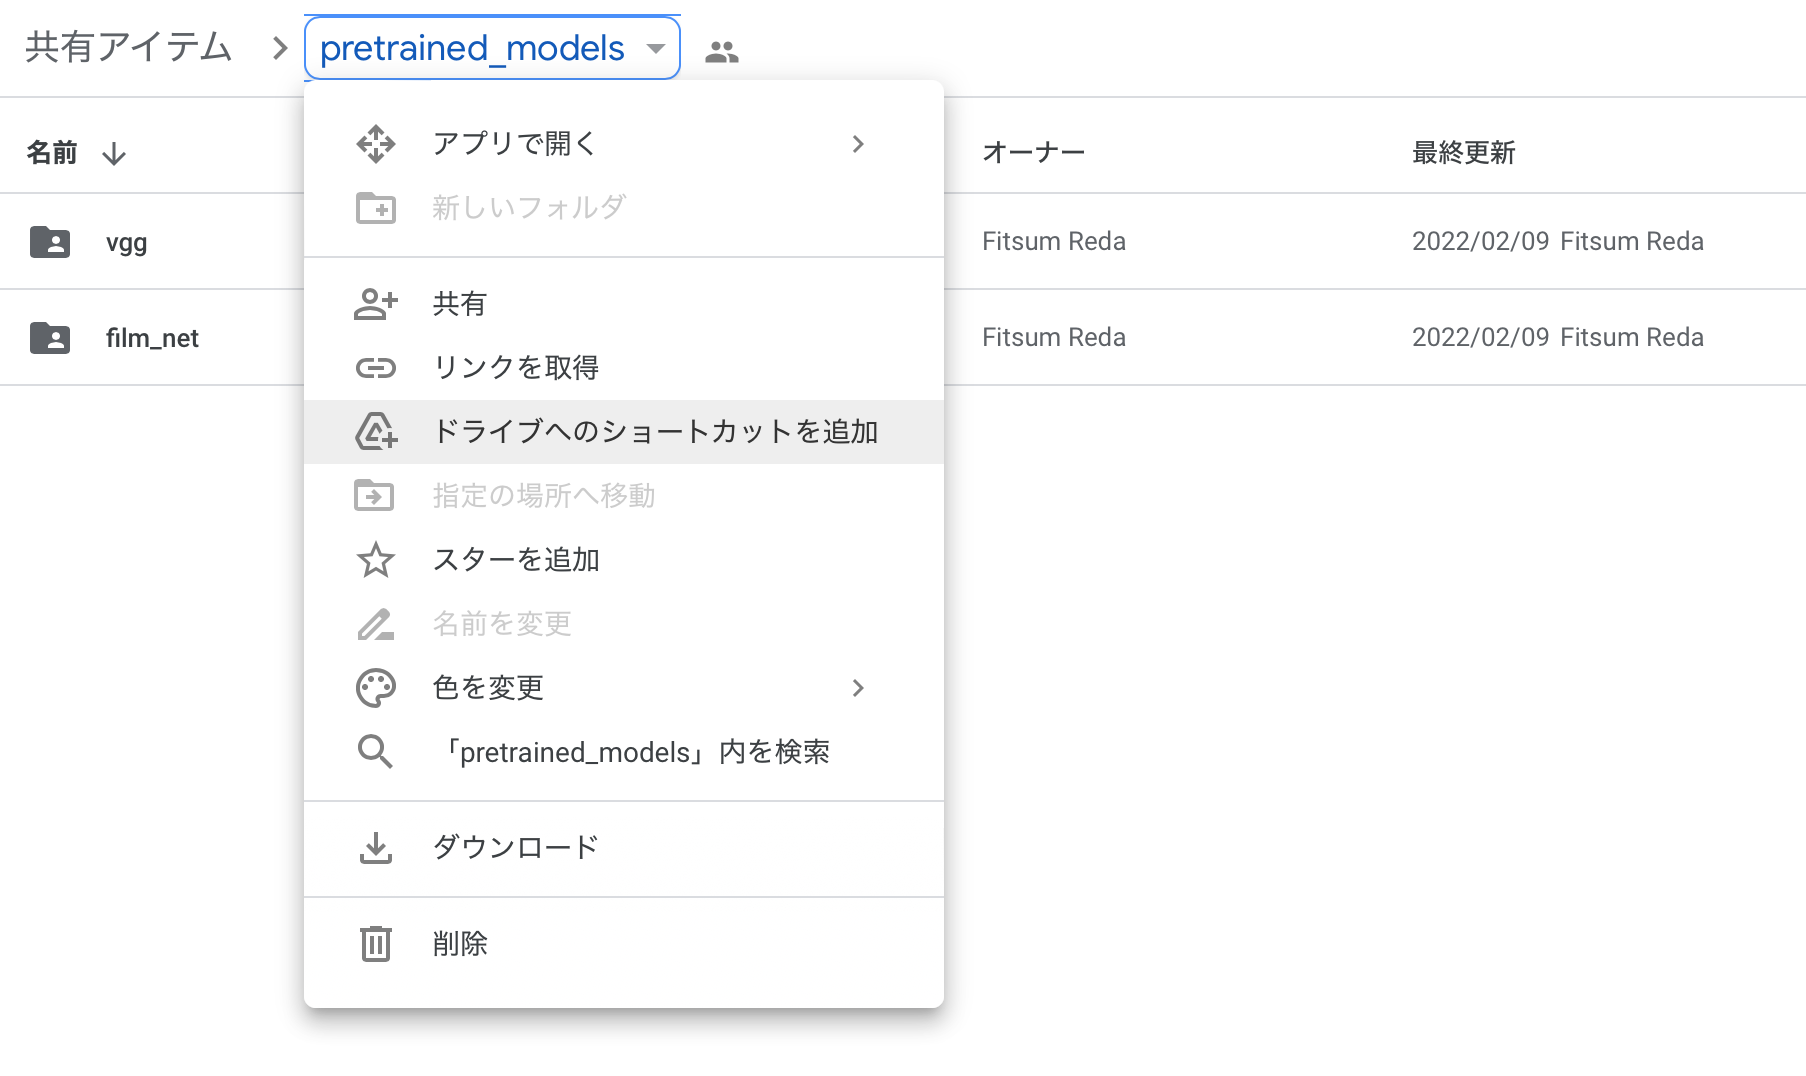

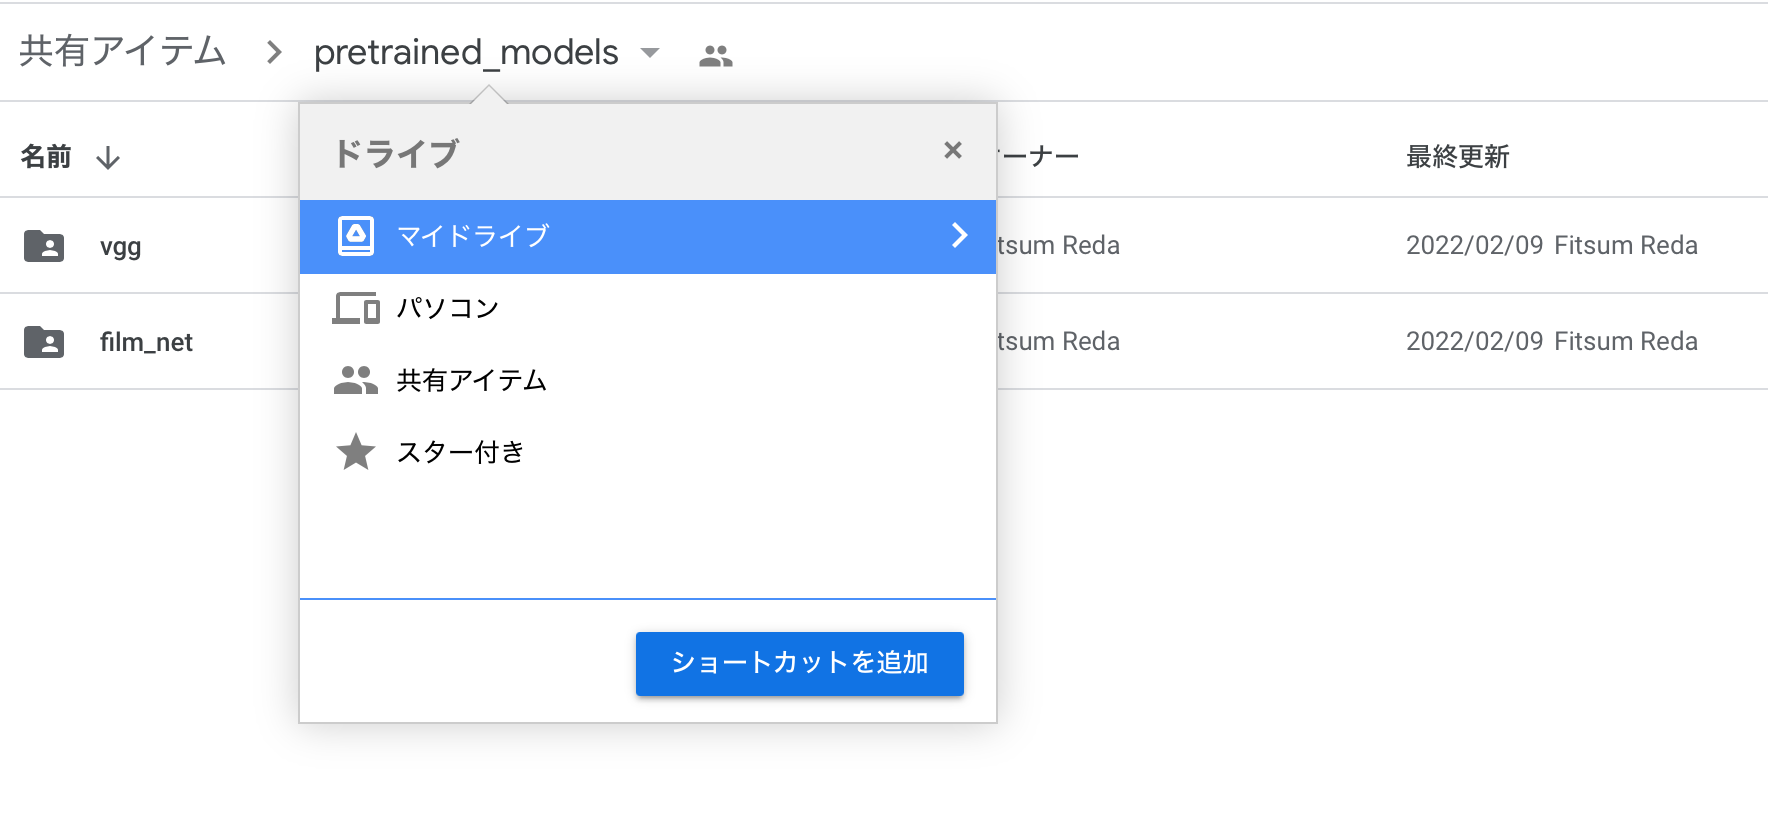

In [ ]:
#@title モデルの確認

from google.colab import drive
drive.mount('/content/drive')

if os.path.isdir("/content/drive/MyDrive/pretrained_models/film_net") == False:
  raise FileNotFoundError("Please add short cut on your own")

In [ ]:
#@title 画像イメージの入力
%cd /content

Language = '\u65E5\u672C\u8A9E\u5165\u529B' #@param ['日本語入力','英語入力']

#@markdown ・　'日本語入力'を選択した場合は、以下を入力
Theme_img_japanese = "\u304D\u3089\u304D\u3089\u5149\u308B\u5C0F\u3055\u306A\u304A\u661F\u3055\u307E" #@param {type:"string"}

from googletrans import Translator
tr = Translator(service_urls=['translate.googleapis.com'])

try:
  text_translate = tr.translate(Theme_img_japanese, dest="en").text
except Exception as e:
  tr = Translator(service_urls=['translate.googleapis.com'])

#@markdown ・　'英語入力'を選択した場合は、以下を入力
Theme_img_english = 'When the blazing sun is gone,When he nothing shines upon,Then Star show a little light,' #@param {type:"string"}
Style = "Cyberpunk" #@param {type:"string"} ["","Abstract artwork","Aerial perspective","Kawaii anime","Baroque artwork","Casein artwork","Children drawing artwork","Chinese watercolor","Comic book art","Cyberpunk","Digital artwork","Fresco","Isometric 3D"] {allow-input: true}
Angle = 'Long shot' #@param {type:"string"} ["","Extreme close-up","Long shot","Medium shot","Over the shoulder point of view","Overhead-angle","Selfie shot","Shot from a birds eye camera","Two shot","Wide shot"] {allow-input: true}
Effects = 'Volumetric light effect' #@param {type:"string"} ["","Bloom light effect","Bokeh effect","Grain effect","Lens flare effect","Light caustics effect","Low shutter effect","Motion blur effect","Neon light effect","Volumetric light effect"] {allow-input: true}
Artists = "James Gurney" #@param {type:"string"} ["","Banksy","Caspar David Friedrich","El Greco","George Inness","Gustav Klimt","Hiroshi Yoshida","Jack Kirby","Jean Michel Basquiat","Joan Miro","Marc Simonetti","Studio Ghibli"] {allow-input: true}
Option1 = 'Amaro filter' #@param {type:"string"}
Option2 = '' #@param {type:"string"}
Option3 = '' #@param {type:"string"}
Option4 = '' #@param {type:"string"}
Option5 = '' #@param {type:"string"}

#@markdown 入力項目の参考サイト<br>https://www.the-ai-art.com/modifiers

if Language=='日本語入力':
  text_prompts_list = text_translate
elif Language=='英語入力':
#  text_prompts_list = [Style," of ",
#                       theme_img_english,",",
#                       Angle,",",
#                       Effects,",",
#                       Artists,",",
#                       Option1,",",
#                       Option2,",",
#                       Option3,",",
#                       Option4,",",
#                       Option5]
#  tmp_text_prompts = "".join(text_prompts_list)
  text_prompts_list = []
  if Artists != "":
    Artists = "by " + Artists

  pre_text_prompts_list = [Theme_img_english,Style,Angle,Effects,Artists,Option1,Option2,Option3,Option4,Option5]
  for text_prompts in pre_text_prompts_list:
    if text_prompts != "":
      text_prompts_list.append(text_prompts)

  text_prompts_list = ",".join(text_prompts_list)

#@markdown 生成する画像数を入力
Number_of_images = 3 #@param {type:"number"}

print("生成イメージ : ",text_prompts_list)

In [ ]:
#@title 画像生成
#@markdown 別のテーマをアニメーションに挿入する場合は、画像イメージの入力に戻って再度テーマを入力. <br>一部不要な画像を削除する場合は"/content/text2animation/"の「img_outputs」フォルダから直接ファイルを削除
j = 0
for j in range(Number_of_images):
  # 画像生成
  image = pipe(text_prompts_list, height=768, width=768).images[0]
  # 保存
  image.save(f"/content/text2animation/img_outputs/{text_prompts_list}_{j:04}.png")

  plt.imshow(plt.imread(f"/content/text2animation/img_outputs/{text_prompts_list}_{j:04}.png"))
  plt.axis('off')
  plt.show()
  print(f'{text_prompts_list}_{j:04}.png')

In [ ]:
#@title 使用画像の確認
#@markdown アニメーションは「img_outputs」内の画像を上から順番に処理するため、画像の並べ替えをする場合は直接ファイル名を編集する<br>
#@markdown 例："01_*****.png"など

img_outputs_path = [os.path.join("/content/text2animation/img_outputs", file) for file in os.listdir("/content/text2animation/img_outputs") if file != '.ipynb_checkpoints']
img_outputs_path.sort(key=os.path.getmtime)

for img_outpus in img_outputs_path:
  plt.imshow(plt.imread(img_outpus))
  plt.axis('off')
  plt.show()
  basename = os.path.basename(img_outpus)
  print(basename)


In [ ]:
#@title 画像のリサイズ
#from PIL import Image
imgfiles_path = [os.path.join("/content/text2animation/img_outputs", file) for file in os.listdir("/content/text2animation/img_outputs") if file != '.ipynb_checkpoints']
imgfiles_path.sort(key=os.path.getmtime)
imgfile = str(imgfiles_path[0])

img = Image.open(imgfile)
img_b = Image.open("/content/text2animation/blank_img.jpg")
img_resize = img_b.resize((img.size))
img_resize.save("/content/text2animation/img_outputs/0000_blank_img.png")
img_resize.save("/content/text2animation/img_outputs/zzzz_blank_img.png")
#print(img_resize.size)
print("完了")

In [ ]:
#@title アニメーション画像の生成
%cd /content/

!python3 -m frame_interpolation.eval.interpolator_cli \
     --pattern "/content/text2animation/img_outputs" \
     --model_path /content/drive/MyDrive/pretrained_models/film_net/Style/saved_model \
     --times_to_interpolate 6

print("完了")

In [ ]:
#@title アニメーションの生成
#@markdown アニメーションの再生時間を秒で入力
%cd /content
length = 30 #@param {type:"number"}

inter_frames_path = "/content/text2animation/img_outputs/interpolated_frames"
inter_frames = [os.path.join(inter_frames_path, file) for file in os.listdir(inter_frames_path) if file != '.ipynb_checkpoints']
inter_frames.sort(key=os.path.getmtime)

init_frame = 1 #Este es el frame donde el vídeo empezará
last_frame = len(inter_frames) #Puedes cambiar i a el número del último frame que quieres generar. It will raise an error if that number of frames does not exist.

min_fps = 10
max_fps = 30

total_frames = last_frame-init_frame

frames = []
tqdm.write('映像生成中...')

for filename in inter_frames:
    frames.append(Image.open(filename))

fps = total_frames/length

from subprocess import Popen, PIPE
p = Popen(['ffmpeg', '-y', '-f', 'image2pipe', '-vcodec', 'png', '-r', str(fps), '-i', '-', '-vcodec', 'libx264', '-r', str(fps), '-pix_fmt', 'yuv420p', '-crf', '17', '-preset', 'veryslow', '/content/text2animation/result/text2animation.mp4'], stdin=PIPE)
for im in tqdm(frames):
    im.save(p.stdin, 'PNG')
p.stdin.close()
p.wait()

print("映像の準備が整いました")

In [ ]:
#@title オプション（Real-ESRGANによる高解像度処理）

print("映像を高解像度処理中、お待ちください...。")
%cd /content/Real-ESRGAN
!python /content/Real-ESRGAN/inference_realesrgan_video.py \
-n RealESRGAN_x4plus \
-i /content/text2animation/result/text2animation.mp4 \
-o /content/text2animation/result \
-s 4

print("完了")

In [ ]:
#@title アニメーションの再生（高解像度処理前）
%cd /content

mp4 = open('/content/text2animation/result/text2animation.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display.HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
#@title アニメーション（mp4）のダウンロード
from google.colab import files

dawnload = '\u9AD8\u89E3\u50CF\u5EA6\u51E6\u7406\u524D' #@param ['高解像度処理前','高解像度処理後']

if dawnload == '高解像度処理前':
  files.download("/content/text2animation/result/text2animation.mp4")
elif dawnload == '高解像度処理後':
  files.download("/content/text2animation/result/text2animation_out.mp4")

In [ ]:
#@title アニメーション画像(img_outputs)のリセット
path = "/content/text2animation/img_outputs"
shutil.rmtree(path)
os.mkdir(path)

print("完了")